In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from datetime import datetime
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import Union
from collections import Counter

In [2]:
SEED = 265
torch.manual_seed(SEED)

DEVICE = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Using device: {DEVICE}")

torch.set_default_dtype(torch.double)

Using device: cuda


In [3]:
class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(32 * 32 * 3, 512)
        self.h1 = nn.Linear(512, 128)
        self.h2 = nn.Linear(128, 32)
        self.output_layer = nn.Linear(32, 2)

    def forward(self, x):
        out = torch.flatten(x, 1)
        out = F.relu(self.input_layer(out))
        out = F.relu(self.h1(out))
        out = F.relu(self.h2(out))
        out = self.output_layer(out)
        return out

    def __str__(self) -> str:
        return "MyMLP"

In [4]:
def load_CIFAR2(train_val_split: float=.9, data_path: str='../data', preprocessor: transforms.Compose=None):
    data_train_val = datasets.CIFAR10(
        data_path,
        train=True,
        download=True,
        transform=preprocessor)
    
    data_test = datasets.CIFAR10(
        data_path,
        train=False,
        download=True,
        transform=preprocessor)

    n_train = int(len(data_train_val)*train_val_split)
    n_val = len(data_train_val) - n_train

    data_train, data_val = random_split(
        data_train_val,
        [n_train, n_val],
        generator=torch.Generator()
    )
    
    label_map = {0: 0, 2: 1}
    class_names = ['airplane', 'bird']
    
    data_train = [(img, label_map[label]) for img, label in data_train if label in [0, 2]]
    data_val = [(img, label_map[label]) for img, label in data_val if label in [0, 2]]
    data_test = [(img, label_map[label]) for img, label in data_test if label in [0, 2]]

    print("Size of training set: ", len(data_train))
    print("Size of validation set: ", len(data_val))
    print("Size of test set: ", len(data_test))

    return (data_train, data_val, data_test)

In [5]:
def display_images(data_set, save=False):
    """
    Display images of planes and birds.
    """
    fig, axes = plt.subplots(nrows=8, ncols=2, constrained_layout=True, figsize=(4,10))
    fig.suptitle("Planes(0) and Birds(1)")
    imgs= (img for img, _ in data_set)
    labels= (label for _, label in data_set)

    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            img, label = next(imgs), next(labels)
            while label != j:
                img, label = next(imgs), next(labels)
            ax.imshow(img, interpolation="nearest", aspect="auto")
            ax.axis('off')

    if save:
        plt.savefig("imgs/train_images.png")
    plt.show()

In [6]:
def train(n_epochs: int, optimizer: optim.Optimizer, model: nn.Module, loss_fn, train_loader: DataLoader, val_loader: DataLoader):
    """
    Train a model with pytorch optimizer.
    """
    print(f"Training {model} with optimizer")
    n_batch = len(train_loader)
    losses_train = []
    losses_val = []

    for epoch in range(1, n_epochs+1):
        model.train()
        loss_train = 0.0
            
        for imgs, labels in train_loader:
            imgs = imgs.to(device=DEVICE, dtype=torch.double)
            labels = labels.to(device=DEVICE)

            outputs = model(imgs)

            loss = loss_fn(outputs,labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)
        
        model.eval()
        with torch.no_grad():
            loss_val = 0.0
            for imgs, labels in val_loader:
                imgs = imgs.to(device=DEVICE, dtype=torch.double)
                labels = labels.to(device=DEVICE)
                outputs = model(imgs)
                loss = loss_fn(outputs, labels)

                loss_val += loss.item()
            losses_val.append(loss_val / n_batch)
                

        if epoch == 1 or epoch % 5 == 0:
            print(f"{datetime.now().time()}, {epoch}, train_loss: {loss_train/n_batch:.5f}, val_loss: {loss_val/n_batch:.5f}")

    return losses_train, losses_val

In [7]:
def train_manual_update(n_epochs: int, lr: float, model: nn.Module, loss_fn, train_loader: DataLoader, val_loader: DataLoader, weight_decay: float=0.0, momentum: float=0.0):
    """
    Train a model with manual update to parameters.
    """
    print(f"Training {model} with manual update")
    n_batch = len(train_loader)
    losses_train = []
    losses_val = []

    # Momentum buffer
    m_b = [torch.zeros_like(p) for p in model.parameters()] 
    for epoch in range(1, n_epochs+1):
        model.train()
        loss_train = 0.0

        for imgs, labels in train_loader:
            imgs = imgs.to(device=DEVICE, dtype=torch.double)
            labels = labels.to(device=DEVICE)

            outputs = model(imgs)
            loss = loss_fn(outputs,labels)
            loss.backward()

            with torch.no_grad():
                for i, p in enumerate(model.parameters()):
                    # L2 regularization
                    if weight_decay != 0:
                        p.grad = p.grad + weight_decay*p.data
                    # Momentum
                    if momentum != 0:
                        m_b[i] = (momentum*m_b[i]) + p.grad
                        p.grad = m_b[i]
                        
                    # Gradient step
                    new_params = p.data-lr*p.grad
                    p.copy_(new_params)
                
                        
                model.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        model.eval()
        with torch.no_grad():
            loss_val = 0.0
            for imgs, labels in val_loader:
                imgs = imgs.to(device=DEVICE, dtype=torch.double)
                labels = labels.to(device=DEVICE)
                outputs = model(imgs)
                loss = loss_fn(outputs, labels)

                loss_val += loss.item()
            losses_val.append(loss_val / n_batch)
                

        if epoch == 1 or epoch % 5 == 0:
            print(f"{datetime.now().time()}, {epoch}, train_loss: {loss_train/n_batch:.5f}, val_loss: {loss_val/n_batch:.5f}")

    return losses_train, losses_val

In [8]:
def evaluate(model: torch.nn, loader: DataLoader, calc_confusion_matrix: bool=False):
    model.eval()
    correct, total, cm, y_pred, y_true = 0, 0, None, list(), list()

    with torch.no_grad():
        # Load images and true labels from each batch
        for imgs, labels in loader:
            imgs = imgs.to(device=DEVICE)
            labels = labels.to(device=DEVICE)

            # Run predictions. Predicted label = prediction with highest confidence
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
        
            # Keep track of total and number of correct predictions
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    # Calculate accuracy
    acc = correct / total

    if calc_confusion_matrix: 
        # Calculate confusion matrix with Sklearn
        # positive = Airplane = 1, negative = Bird = 0
        cm = confusion_matrix(y_true, y_pred)
        return acc, cm
    else: 
        return acc

In [9]:
def compare_training_functions(train_loader: DataLoader, val_loader: DataLoader):
    """
    Used to compare the losses and accuracies of the different gradient descent implementations
    """
    batch_size = 256
    n_epochs = 5
    loss_fn = nn.CrossEntropyLoss()
    seed = SEED
    hparam = {"lr": 0.01, "weight_decay": 0.01, "momentum": 0.9}
    
    print("\tParameters:")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {n_epochs}")
    print(f"Loss function: {loss_fn}")
    print(f"Seed: {seed}")
    [print(f"{param}: {value}") for param, value in hparam.items()]
    print("\n", "="*50)
    
    print("\n", "-"*6, "Using Pytorch SGD", "-"*6)
    torch.manual_seed(SEED)
    model_auto = MyMLP()
    model_auto.to(device=DEVICE)
    optimizer = optim.SGD(model_auto.parameters(), **hparam)

    train_loss_auto, val_loss_auto = train(n_epochs, optimizer, model_auto, loss_fn, train_loader, val_loader)
    train_acc_auto = evaluate(model_auto, train_loader)
    val_acc_auto = evaluate(model_auto, val_loader)
    
    print("\n", "-"*3, "Accuracies", "-"*3)
    print(f"Training accuracy: {round(train_acc_auto, 2)}")
    print(f"Validation accuracy: {round(val_acc_auto, 2)}")
    
    print("\n", "-"*6, "Using manual update", "-"*6)
    torch.manual_seed(SEED)
    model_manual = MyMLP()
    model_manual.to(device=DEVICE)
    train_loss_manual, val_loss_manual = train_manual_update(n_epochs, model=model_manual, train_loader=train_loader, val_loader=val_loader, loss_fn=loss_fn, **hparam)
    train_acc_manual = evaluate(model_manual, train_loader)
    val_acc_manual = evaluate(model_manual, val_loader)
    
    print("\n", "-"*3, "Accuracies", "-"*3)
    print(f"Training accuracy: {round(train_acc_manual, 2)}")
    print(f"Validation accuracy: {round(val_acc_manual, 2)}")

    print("\n", "-"*6, "Test for equal result", "-"*6)
    print(f"Training loss is equal: {train_loss_auto[-1]:.5f}={train_loss_manual[-1]:.5f}")
    print(f"Validation loss is equal: {val_loss_auto[-1]:.5f}={val_loss_manual[-1]:.5f}")
    print(f"Training accuracy is equal: {train_acc_auto:.5f}={train_acc_manual:.5f}")
    print(f"Validation accuracy is equal: {val_acc_auto:.5f}={val_acc_manual:.5f}")

In [10]:
def train_instances(n_epochs: int, batch_size: int, train_loader: DataLoader, val_loader: DataLoader):
    """
    Train on different hyperparameters using Pytorch SGD
    """
    loss_fn = nn.CrossEntropyLoss()
    seed = SEED

    print("\tGlobal parameters:")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {n_epochs}")
    print(f"Loss function: {loss_fn}")
    print(f"Seed: {seed}")
    
    hyper_params = [
        {"lr": 0.01, "weight_decay": 0.0, "momentum": 0.0},
        {"lr": 0.01, "weight_decay": 0.01, "momentum": 0.0},
        {"lr": 0.01, "weight_decay": 0.9, "momentum": 0.0},
        {"lr": 0.01, "weight_decay": 0.0, "momentum": 0.01},
        {"lr": 0.01, "weight_decay": 0.0, "momentum": 0.9},
        {"lr": 0.01, "weight_decay": 0.01, "momentum": 0.9},
        {"lr": 0.01, "weight_decay": 0.9, "momentum": 0.01},
    ]

    models = []
    accuracies = []

    # Train both models with the different hyperparameters
    for hparam in hyper_params:
        print("\n", "="*50)
        print("\tCurrent parameters: ")
        [print(f"{key}:{value}") for key, value in hparam.items()]

        print("\n", "-"*6, "Using Pytorch SGD", "-"*6)
        torch.manual_seed(SEED)
        model_auto = MyMLP()
        model_auto.to(device=DEVICE)
        optimizer = optim.SGD(model_auto.parameters(), **hparam)

        train(n_epochs, optimizer, model_auto, loss_fn, train_loader, val_loader)
        train_acc_auto = evaluate(model_auto, train_loader)
        val_acc_auto = evaluate(model_auto, val_loader)
        models.append(model_auto)
        accuracies.append(val_acc_auto)
        
        print("\n", "-"*3, "Accuracies", "-"*3)
        print(f"Training accuracy: {round(train_acc_auto, 2)}")
        print(f"Validation accuracy: {round(val_acc_auto, 2)}")
    return models, accuracies, hyper_params

Files already downloaded and verified
Files already downloaded and verified
Size of training set:  8956
Size of validation set:  1044
Size of test set:  2000


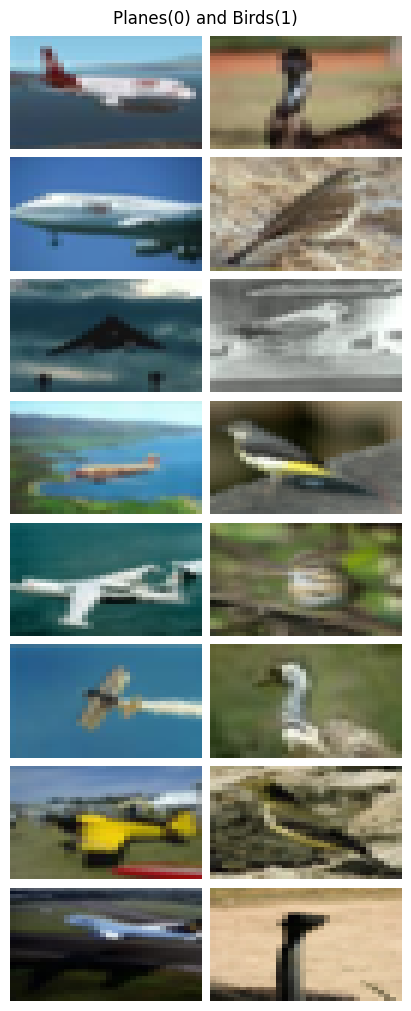

Class distribution: 
Label: 0 -> 4529 images
Label: 1 -> 4427 images


In [11]:
# Analyse Images
training_set, _, _ = load_CIFAR2()

display_images(training_set, save=True)

print("Class distribution: ")
counter = Counter([label for _, label in training_set])
for label, count in counter.items():
    print(f"Label: {label} -> {count} images")


In [12]:
# Add normalization from training data
tensor_train, _, _ = load_CIFAR2(preprocessor=transforms.ToTensor())
imgs = torch.stack([img for img, _ in tensor_train])

normalizer = transforms.Normalize(
    imgs.mean(dim=(0,2,3)),
    imgs.std(dim=(0,2,3))
)

preprocessor = transforms.Compose([
    transforms.ToTensor(),
    normalizer
])

Files already downloaded and verified
Files already downloaded and verified
Size of training set:  8956
Size of validation set:  1044
Size of test set:  2000


In [13]:
n_epochs = 50
batch_size = 256

# Load data with preprocessor
cifar_train, cifar_val, cifar_test = load_CIFAR2(preprocessor=preprocessor)
train_loader = DataLoader(cifar_train, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(cifar_val, shuffle=False, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Size of training set:  8956
Size of validation set:  1044
Size of test set:  2000


In [14]:
# Compare both training functions and check for equal output (5 decimal precision)
compare_training_functions(train_loader, val_loader)

	Parameters:
Batch size: 256
Epochs: 5
Loss function: CrossEntropyLoss()
Seed: 265
lr: 0.01
weight_decay: 0.01
momentum: 0.9


 ------ Using Pytorch SGD ------
Training MyMLP with optimizer
18:34:38.206420, 1, train_loss: 0.61852, val_loss: 0.07974
18:34:39.625008, 5, train_loss: 0.37740, val_loss: 0.06571

 --- Accuracies ---
Training accuracy: 0.85
Validation accuracy: 0.81

 ------ Using manual update ------
Training MyMLP with manual update
18:34:40.228814, 1, train_loss: 0.61852, val_loss: 0.07974
18:34:41.706117, 5, train_loss: 0.37740, val_loss: 0.06571

 --- Accuracies ---
Training accuracy: 0.85
Validation accuracy: 0.81

 ------ Test for equal result ------
Training loss is equal: 0.37740=0.37740
Validation loss is equal: 0.06571=0.06571
Training accuracy is equal: 0.85373=0.85373
Validation accuracy is equal: 0.81034=0.81034


In [15]:
# Train model with different hyperparameters
models, accuracies, hyper_params = train_instances(n_epochs, batch_size, train_loader=train_loader, val_loader=val_loader)

	Global parameters:
Batch size: 256
Epochs: 50
Loss function: CrossEntropyLoss()
Seed: 265

	Current parameters: 
lr:0.01
weight_decay:0.0
momentum:0.0

 ------ Using Pytorch SGD ------
Training MyMLP with optimizer
18:34:42.283823, 1, train_loss: 0.67897, val_loss: 0.09691
18:34:43.691391, 5, train_loss: 0.53843, val_loss: 0.07952
18:34:45.470166, 10, train_loss: 0.45850, val_loss: 0.07291
18:34:47.250295, 15, train_loss: 0.42210, val_loss: 0.06977
18:34:49.008428, 20, train_loss: 0.38778, val_loss: 0.06739
18:34:50.712020, 25, train_loss: 0.35527, val_loss: 0.06576
18:34:52.469025, 30, train_loss: 0.32326, val_loss: 0.06420
18:34:54.201001, 35, train_loss: 0.29054, val_loss: 0.06289
18:34:55.878545, 40, train_loss: 0.25878, val_loss: 0.06229
18:34:57.563283, 45, train_loss: 0.24598, val_loss: 0.06466
18:34:59.243173, 50, train_loss: 0.23924, val_loss: 0.06407

 --- Accuracies ---
Training accuracy: 0.93
Validation accuracy: 0.82

	Current parameters: 
lr:0.01
weight_decay:0.01
moment

In [16]:
# Find the model with highest accuracy
highest_acc = max(accuracies)
selected_idx = accuracies.index(highest_acc)
selected_model = models[selected_idx]

Used hyperparameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9}
Test Accuracy of selected model: 0.84


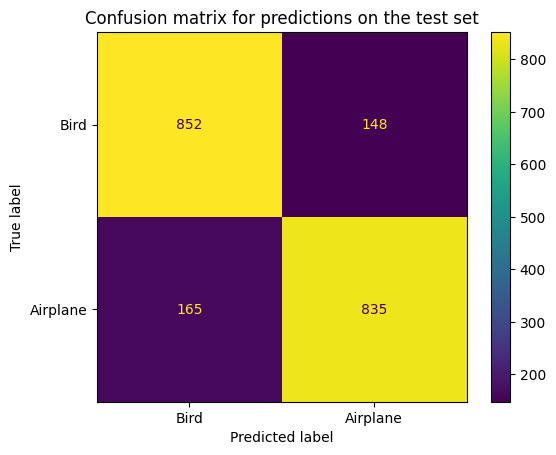

In [17]:
# Test performance of chosen model on unseen data
test_loader = DataLoader(cifar_test, shuffle=False, batch_size=batch_size)
acc, cm = evaluate(selected_model, test_loader, calc_confusion_matrix=True)
print(f"Used hyperparameters: {hyper_params[selected_idx]}")
print(f"Test Accuracy of selected model: {acc:.2f}")

# Visualize the confusion matrix. Positive = Airplane = 1, Negative = Bird = 0
cmplt = ConfusionMatrixDisplay(cm, display_labels=["Bird", "Airplane"])
cmplt.plot()
cmplt.ax_.set_title("Confusion matrix for predictions on the test set")
plt.savefig("imgs/confusion_matrix_test.png")
plt.show()

In [18]:
def find_wrong_predictions(model, loader, wrong=True, label=None, preprocessor=normalizer, save=False):
    """
    Display some examples of wrongly classified images
    """
    model.eval()

    kept_imgs, kept_labels, kept_preds = [],[],[]

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device=DEVICE)
            labels = labels.to(device=DEVICE)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            wrong_preds = torch.eq(labels, predicted)

            kept_imgs+=[img.permute(1,2,0) for img in imgs[~wrong_preds]]
            kept_labels+=labels[~wrong_preds].tolist()
            kept_preds+=predicted[~wrong_preds].tolist()

    kept_imgs = iter(kept_imgs)
    kept_labels = iter(kept_labels)
    kept_preds = iter(kept_preds)

    fig, axes = plt.subplots(nrows=8, ncols=2, constrained_layout=True, figsize=(4,10))
    fig.suptitle("Wrong predictions\nTrue label: Plane(0)  True label: Bird(1)\nPredicted: Bird(1)  Predicted: Plane(0)")
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            img, pred = next(kept_imgs), next(kept_preds)
            while label != j:
                img, label = next(kept_imgs), next(kept_preds)
                img = img.to(device='cpu')
            ax.imshow(img, interpolation="nearest", aspect="auto")
            ax.axis('off')

    if save:
        plt.savefig("imgs/wrong_predictions.png")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

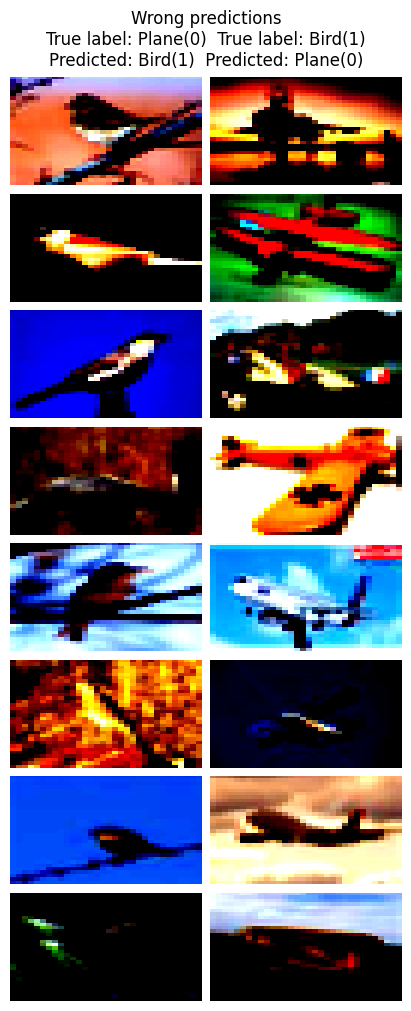

In [19]:
# Display wrong predictions
find_wrong_predictions(selected_model, test_loader, save=True)